## LETKF
- データ同化Aの講義資料をみる
- 8メンバーで走る

### アルゴリズム
$ \tilde{P^a} = [(N-1)I/\rho + dY^T R^{-1} dY]^{-1} $

$ T = \tilde{P^a} dY^T R^{-1}(y^o - \overline{dY^f}) + [(N-1) \tilde{P^a}]^{1/2} $

$ X^a = x^f + dX^f T$

### localiztion
- 各点で分けて解析を行う．
- その際に

### Question
- 

## LETKFのdebug
TODO
- [x] LETKF実装方針の検討
    - [x] EnSRF(ETKF)を拡張: 
        - serialize ETKFを拡張
        - $y^o$の各変数で両隣を合わせた3変数の同化を行う．
    - [ ] 新たにLETKFを実装
- [ ] その他はちゃんと動いているか確認
- [ ] localizationの方法の確立
    - [x] K-loc : serialize KF($y^o$の40成分を一つずつ同化)のKalman gainに$ \rho_i $をかける．

- [ ] リファクタリング
  - [ ] 計算量の評価
  - [ ] 各成分の同化で不要な成分の計算を省く
  - [ ] 一般の観測次元で実装

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# モジュールの読み込み
import sys
sys.path.append('./module')
from utils import make_lorenz96, rk4, error_series_kf, plot_error_KF, estimate_error_with_params

from numpy import sqrt, trace, zeros, identity, exp, random
from numpy.random import multivariate_normal, choice
from numpy.linalg import inv
import scipy
from scipy.linalg import sqrtm


# TODO削除: 開発用
from kalman_filters import EnsembleSquareRootFilter as ETKF

In [2]:
# Lorenz96の設定
J = 40
F = 8
lorenz = make_lorenz96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(0, x, 0.01, lorenz)
    return x

# 単位行列
I = np.identity(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
R = I

# 観測値と真値
y = np.load('data/obs_atr.npy')
true = np.load('data/true_atr.npy')

# KFの初期値
np.random.seed(1)
x_0 = true[np.random.randint(len(true)-1)]
P_0 = 25*I

In [22]:
class LETKF:
    def __init__(self, M, H, Q, R, y, x_0, P_0, m=40, dt=0.05, alpha=1, sigma=3):
        self.M = M
        self.H = H
        self.Q = Q
        self.R = R
        self.y = y
        self.m = m # アンサンブルメンバー数
        self.dt = dt
        
        # 実装で技術的に必要
        self.dim_x = Q.shape[0]
        self.I = identity(m)
        
        self.alpha = alpha # inflation用の定数
        self.sigma = sigma

        # filtering実行用
        self.x = [] # 記録用
        self.trP = []

        self._initialize(x_0, P_0, m)

  #　初期状態
    def _initialize(self, x_0, P_0, m):
        random.seed(0)
        self.X = x_0 + multivariate_normal(np.zeros(self.dim_x), P_0, m) # (m, J)
        self.x_mean = self.X.mean(axis=0)
    
  # 逐次推定を行う
    def forward_estimation(self):
        for y_obs in self.y:
            self._forecast()
            self._update(y_obs)

    # 更新/解析
    def _update(self, y_obs):
        X_f=self.X; x_f=self.x_mean; alpha = self.alpha; H = self.H; R = self.R; m = self.m; I = self.I
        
        for i in range(40):
            # dX, dYを計算
            # TODO: 計算量の削減
            X_f=self.X; x_f=X_f.mean(axis=0)
            dX_f = X_f - x_f # (m, dim_x)
            dX_f = sqrt(alpha)*dX_f # inflation
            dY = (H@dX_f.T).T # (m, dim_y)
        
            # Kalman gain
            K = dX_f.T@dY@inv(dY.T@dY + (m-1)*R) # (dim_x, dim_y)
            K = (self._rho(i)*K.T).T # localization
            
            # 平均を更新
            dy = self._restrict_observation(i, y_obs - H@x_f)
            x_a = x_f + K@(dy) # dim_x

            # dXを変換, I - dY^t(dYdY^t + (m-1)R)dYの平方根をとる
            S = self._symmetric(I - dY@inv(dY.T@dY + (m-1)*R)@dY.T)
            T = np.real(sqrtm(S)) # (m, m)
            self.X = x_a + (dX_f.T@T).T # (m, dim_x)
            
        self.X = X_f
        
        # 記録: 更新した値のアンサンブル平均xを保存, 推定誤差共分散P_fのtraceを保存
        self.x.append(self.X.mean(axis=0))
#         self.trP.append(sqrt(trace(dX_f.T@dX_f)/40))

    # 予報/時間発展
    def _forecast(self):
        # アンサンブルで x(k) 予測
        for i, s in enumerate(self.X):
            self.X[i] = self.M(s, self.dt)

        self.x_mean = self.X.mean(axis=0)
    
    def _restrict_observation(self, i, dy):
            r = zeros(40)
            r[i] = 1
            r[(i+1)%40]=1; r[(i-1)%40]=1
            r[(i+2)%40]=1; r[(i-2)%40]=1
            return r*dy
     
    def _rho(self, i):
        rho = np.array([exp(-min([(i-j)**2, (i+J-j)**2])/self.sigma) for j in range(self.dim_x)])
        return rho
    
    def _symmetric(self, S):
        return 0.5*(S + S.T)

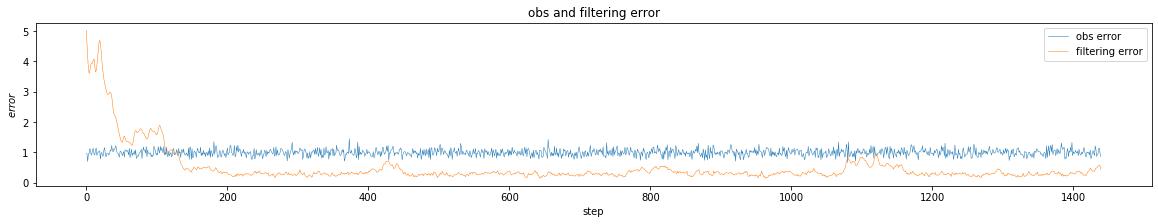

CPU times: user 5min 12s, sys: 2.52 s, total: 5min 14s
Wall time: 39.7 s


(8, 0, 0.33035835304686867)

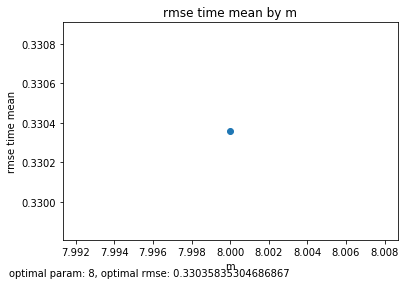

In [29]:
%%time
m = 8
alpha = 1.22
sigma = 2.5
letkf = LETKF(M, H, Q, R, y, x_0, P_0, m=m, alpha=alpha, sigma=sigma)
letkf.forward_estimation()
plot_error_KF(true, y, [letkf.x], trPs=[])
estimate_error_with_params(true, [letkf.x], [m], 'm')

ETKFと比較

ざっくりgrid search


In [27]:
# m=8
# spin_up = 200
# duration = 20

# num_alpha = 10
# num_sigma = 8
# params_alpha = np.linspace(1., 2, num=num_alpha)
# params_sigma = np.arange(1, 1+num_sigma)
# errors = np.zeros((num_alpha, num_sigma))

# for i in range(num_alpha):
#     alpha = params_alpha[i]
#     for j in range(num_sigma):
#         sigma = params_sigma[j]
#         letkf = LETKF(M, H, Q, R, y[:spin_up+duration], x_0, P_0, m=m, alpha=alpha, sigma=sigma)
#         letkf.forward_estimation()
#         error = error_series_kf(true, letkf.x, time_index=np.arange(duration)+spin_up).mean()
#         errors[i,j] = error
#         print('complete: alpha: {}, sigma: {}, error: {}'.format(alpha, sigma, error))
#     print('=======================')
# df = pd.DataFrame(errors, index=params_alpha, columns=params_sigma)
# df.to_csv('data/letkf/letkf_alpha_sigma_rough.csv')

complete: alpha: 1.0, sigma: 1, error: 5.27439516736006
complete: alpha: 1.0, sigma: 2, error: 5.315875228171975
complete: alpha: 1.0, sigma: 3, error: 5.040941277730434
complete: alpha: 1.0, sigma: 4, error: 4.85199595890044
complete: alpha: 1.0, sigma: 5, error: 5.271152845695431
complete: alpha: 1.0, sigma: 6, error: 4.931690224318263
complete: alpha: 1.0, sigma: 7, error: 5.090155783722726
complete: alpha: 1.0, sigma: 8, error: 5.116770041958946
complete: alpha: 1.1111111111111112, sigma: 1, error: 1.4384464663077168
complete: alpha: 1.1111111111111112, sigma: 2, error: 2.952737430066834
complete: alpha: 1.1111111111111112, sigma: 3, error: 3.141031730555277
complete: alpha: 1.1111111111111112, sigma: 4, error: 0.6906034495157695
complete: alpha: 1.1111111111111112, sigma: 5, error: 1.6613333142416646
complete: alpha: 1.1111111111111112, sigma: 6, error: 1.4640093584758347
complete: alpha: 1.1111111111111112, sigma: 7, error: 0.8261770196139583
complete: alpha: 1.1111111111111112, 

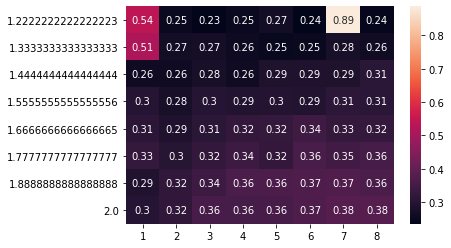

In [48]:
df = pd.read_csv('data/letkf/letkf_alpha_sigma_rough.csv', index_col=0, header=0)
df = pd.DataFrame(errors, index=params_alpha, columns=params_sigma)
sns.heatmap(df.iloc[2:, :], annot=True)

In [11]:
# TODO: alpha = 1.22, sigma = 3で詳細に探索
m=8
spin_up = 200
duration = 20

num_alpha = 11
num_sigma = 11
params_alpha = np.linspace(1.22-0.05, 1.22+0.05, num=num_alpha)
params_sigma = np.arange(num_sigma)*0.1 + 2.5
errors = np.zeros((num_alpha, num_sigma))

for i in range(num_alpha):
    alpha = params_alpha[i]
    for j in range(num_sigma):
        sigma = params_sigma[j]
        letkf = LETKF(M, H, Q, R, y[:spin_up+duration], x_0, P_0, m=m, alpha=alpha, sigma=sigma)
        letkf.forward_estimation()
        error = error_series_kf(true, letkf.x, time_index=np.arange(duration)+spin_up).mean()
        errors[i,j] = error
        print('complete: alpha: {}, sigma: {}, error: {}'.format(alpha, sigma, error))
    print('=======================')
df = pd.DataFrame(errors, index=params_alpha, columns=params_sigma)
df.to_csv('data/letkf/letkf_alpha_sigma_detail.csv')

complete: alpha: 1.17, sigma: 2.5, error: 0.4675236109370842
complete: alpha: 1.17, sigma: 2.6, error: 0.23938556700948532
complete: alpha: 1.17, sigma: 2.7, error: 0.8673175968783307
complete: alpha: 1.17, sigma: 2.8, error: 0.8274008578903651
complete: alpha: 1.17, sigma: 2.9, error: 1.2862721443291816
complete: alpha: 1.17, sigma: 3.0, error: 3.0157194917550134
complete: alpha: 1.17, sigma: 3.1, error: 1.1761230739449153
complete: alpha: 1.17, sigma: 3.2, error: 1.2832216098721265
complete: alpha: 1.17, sigma: 3.3, error: 0.40386502547767505
complete: alpha: 1.17, sigma: 3.4, error: 0.5072630626858194
complete: alpha: 1.17, sigma: 3.5, error: 1.1981449375155622
complete: alpha: 1.18, sigma: 2.5, error: 1.6412127326114452
complete: alpha: 1.18, sigma: 2.6, error: 0.6568384478905127
complete: alpha: 1.18, sigma: 2.7, error: 0.45054784455688884
complete: alpha: 1.18, sigma: 2.8, error: 0.9353676493624363
complete: alpha: 1.18, sigma: 2.9, error: 1.9326775318071499
complete: alpha: 1.18

,2.5,2.6,2.7,2.8,2.9,3.0,3.1,3.2,3.3,3.4,3.5
1.17,0.467524,0.239386,0.867318,0.827401,1.286272,3.015719,1.176123,1.283222,0.403865,0.507263,1.198145
1.18,1.641213,0.656838,0.450548,0.935368,1.932678,0.246796,1.412841,0.817162,0.357527,0.779504,0.838893
1.19,1.071649,0.521439,0.301531,1.460963,0.439746,0.520727,0.647157,0.300392,0.378265,0.409367,0.231177
1.20,1.237275,0.457461,0.563442,0.837430,0.234171,0.255302,1.178690,0.845361,0.336483,0.322938,0.261620
1.21,0.519347,0.226236,0.336073,0.558860,0.258018,0.236083,0.236811,0.391619,1.080809,0.223597,0.224093
1.22,0.349519,0.284207,0.230814,0.292104,0.237280,0.213483,0.238598,0.240896,0.241213,0.257791,0.236244
1.23,0.269979,0.256155,0.229667,0.307884,0.246102,0.248854,0.256172,0.255063,0.229103,0.261240,0.239327
1.24,0.272751,0.250317,0.238434,0.237905,0.237453,0.245720,0.251310,0.230079,0.235306,0.251096,0.248052
1.25,0.236073,0.250458,0.240768,0.273349,0.234726,0.231490,0.237740,0.239058,0.231451,0.235379,0.234004
1.26,0.257978,0.273718,0.243675,0.238587,0.254040,0.249318,0.243332,0.235016,0.248001,0.240844,0.236606


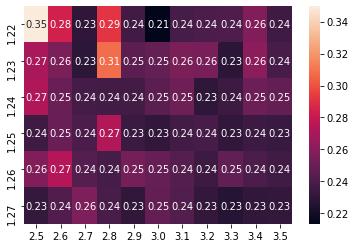

In [16]:
sns.heatmap(df.iloc[5:], annot=True)
df

In [ ]:
# TODO: kalman_filters.pyに決定版を保存
# 未完成
# LocalEnsembleTransformKalmanFilter(LETKF)
"""
Parameters
M: callable(x, dt)
  状態遷移関数
H: ndarray(dim_y, dim_x)
  観測行列  
Q: ndarray(dim_x, dim_x)
  モデルの誤差共分散行列 
R: ndarray(dim_y, dim_y)
  観測の誤差共分散行列
x_0: 状態変数の初期値
P_0: 誤差共分散の初期値
m: アンサンブルメンバーの数
dt: 同化時間step幅
alpha: inflation factor
localization: localizationの設定
x: ndarray(dim_x)

"""
class LocalEnsembleTransformKalmanFilter:
    def __init__(self, M, H, Q, R, y, x_0, P_0, m=10, dt=0.05, alpha=1, rho=np.ones(10)):
        self.M = M
        self.H = H
        self.Q = Q
        self.R = R
        self.y = y
        self.m = m # アンサンブルメンバー数
        self.dt = dt
        
        # 実装で技術的に必要
        self.dim_x = Q.shape[0]
        self.I = identity(m)
        
        self.alpha = alpha # inflation用の定数
        self.rho = rho # localization用のベクトル sizeはm

        # filtering実行用
        self.x = [] # 記録用
        self.x_f = []
        self.trP = []

        self._initialize(x_0, P_0, m)

  #　初期状態
    def _initialize(self, x_0, P_0, m):
        self.X = x_0 + multivariate_normal(np.zeros(self.dim_x), P_0, m) # (m, J)
        self.x_mean = self.X.mean(axis=0)
    
  # 逐次推定を行う
    def forward_estimation(self):
        for y_obs in self.y:
            self._forecast()
            self._update(y_obs)

    # 更新/解析
    def _update(self, y_obs):
        x_f = self.x_mean; X_f = self.X; H = self.H; R = self.R; m = self.m; rho = self.rho; alpha = self.alpha

        # # dX, dYを計算
        dX_f = X_f - x_f # (m, dim_x)
        # dX_f = sqrt(self.alpha)*dX_f # 旧srfでのinflation
        dY = (H@dX_f.T).T # (m, dim_y)
        y_mean = dY.mean(axis=0) # dim_y
        
        # localization
#         self.C = dY@inv(R) # (m, dim_y)
        for i in range(self.dim_x):
            C = self._rho(i)*dY@inv(R) # Cの各i行にrho_iをかける (m, dim_y)

#             print(C_local@dY.T)
            P_at = inv(((m-1)/alpha)*self.I + C@dY.T) # (m, m)
            
            print(C@(y_obs - y_mean) )
            T = (P_at@C@(y_obs - y_mean) + sqrtm((m-1)*P_at).T).T # (m, m)

            print(dX_f.T@T)
            self.X[:, i] = x_f[i] + (dX_f.T@T).T[:, i] # (m, dim_x)

        # 記録: 更新した値のアンサンブル平均xを保存, 推定誤差共分散P_fのtraceを保存
        self.x.append(self.X.mean(axis=0))
        self.trP.append(sqrt(trace(dX_f.T@dX_f)/40))


    # 予報/時間発展
    def _forecast(self):
        # アンサンブルで x(k) 予測
        for i, s in enumerate(self.X):
            self.X[i] = self.M(s, self.dt)

        self.x_mean = self.X.mean(axis=0)
        self.x_f.append(self.x_mean)
     
    def _rho(self, i):
        rho = np.array([exp(-min([(i-j)**2, (i+J-j)**2])/self.sigma) for j in range(self.dim_x)])
        return rho